# Martin Iniguez de Onzono Muruaga. AAND4 Numerical.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import scipy.io  

In [2]:
data = scipy.io.loadmat('c1p8.mat')
rho = data['rho'].flatten()
stim = data['stim'].flatten()
t_res = 2e-3 
t_stim = 20*60 # s

idx = np.array(np.where(rho==True)).flatten()
t_rho = idx*t_res

## Ex 1. Spike-triggered average.

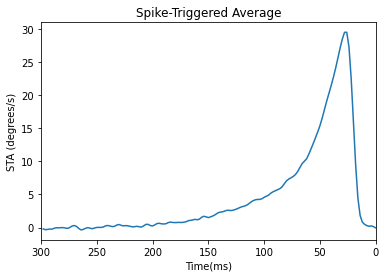

In [3]:
sta = np.zeros(150)
tau = 300e-3
lag = int(tau/t_res)

idx = idx[np.where(idx>=150)]
counts = idx.shape[0]

for i in idx:
    sta += stim[i-150:i]

sta /= counts

time = np.arange(0,0.3,t_res)*1000 # ms
sta_f = np.flip(sta)[0:time.shape[0]]
plt.xlim(tau*1000,0)
plt.plot(time,sta_f);
plt.ylabel('STA (degrees/s)')
plt.xlabel('Time(ms)')

plt.title('Spike-Triggered Average');

### In this exercise, looping over spikes is actually much faster. Why?

That is because the rho signal is very long and thus, performing the convolution is a very long process, compared to just looking at the spike times. Also, there is only one trial, which makes it so much easier for the looping algorithm.

## Ex 2. Linear encoding kernel D.

In [13]:
def firing_rate(spikes,t_stim):
    mean_fire = np.sum(spikes)/t_stim
    return mean_fire/1000

The mean firing rate is 0.0446675 spikes/s.
The variance of the stimulus is 5.10733715736814 degrees^2/s^2.


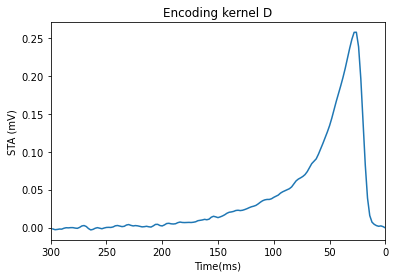

In [14]:
mean = firing_rate(rho,t_stim)
var = np.var(stim)*t_res
D = mean*sta/var

D_f = np.flip(D)[0:time.shape[0]]
plt.plot(time,D_f)
plt.xlim(tau*1000,0)
plt.ylabel('STA (mV)')
plt.xlabel('Time(ms)')

plt.title('Encoding kernel D') 
print(f'The mean firing rate is {mean} spikes/s.')
print(f'The variance of the stimulus is {var} degrees^2/s^2.')

## Ex 3. Predicting the neuron's response.

In [9]:
def rect_avg(spikes,width,t_res):
        
    rect_wind = np.ones(np.int(width/t_res))/width
    rect = np.convolve(spikes,rect_wind,mode='same')

    return rect

def est_fire(D,stim,mean):
    r_l = np.convolve(D,stim,'same')
    r0 = mean - r_l.mean()
    return r0 + r_l

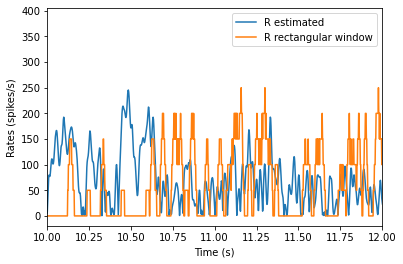

In [19]:
r_est = est_fire(D,stim,mean)
# r_l_shaped -= np.min(r_l_shaped) 
# r_l_shaped = r_l/ np.mean(r_l)*t_res*mean
times = np.arange(0,t_stim,t_res) # s

plt.plot(times,abs(r_est),label='R estimated')

r_avg = rect_avg(rho,20e-3,t_res)

plt.plot(times,r_avg,label='R rectangular window');
plt.xlim([10,12])
plt.xlabel('Time (s)')
plt.ylabel('Rates (spikes/s)');
plt.legend();

It can be seen that the estimated R from the D(tau) is a continuous function, more constant but with lower values. The rectangular window one, however, has a more spiking behavior and thus, those spikes have higher values (so both of themhave the same mean).

## Ex. 4. Extra.

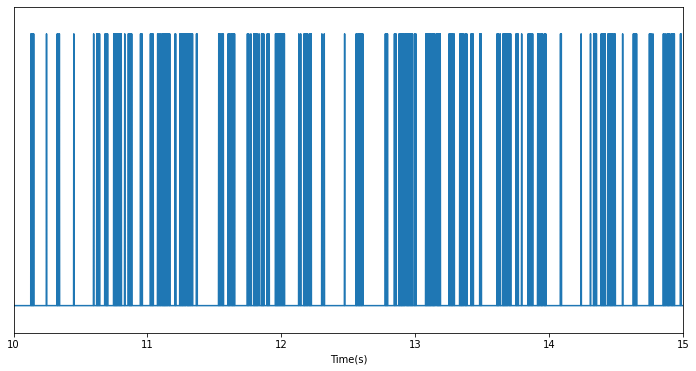

In [8]:
plt.figure(figsize=(12,6))
plt.plot(times,rho)
plt.xlabel('Time(s)')
plt.yticks([])
plt.ylim([-0.1,1.1])
plt.xlim([10,15]);

### b) Plot the ISI histogram.

In [9]:
def get_ISI(t_spikes,hist=False,alpha=1,label=None,hist_not_norm=False):
    ISIs=np.abs(np.diff(t_spikes)).flatten()
    if hist:
        counts, bins = np.histogram(ISIs,bins=100)
#         plt.hist(bins[:-1], bins, weights=counts/np.sum(counts),alpha=alpha,label=label);
        plt.hist(bins[:-1], bins, weights=counts/np.sum(counts),alpha=alpha,label=label);
        plt.xlabel('ISI (s)')
    if hist_not_norm:
        plt.hist(ISIs,bins=100,label=label)
    return ISIs 


def cv(ISI):
    stdv = np.std(ISI)
    mean_I = np.mean(ISI)
    cv_I = np.round(stdv/mean_I,2)
    return cv_I 

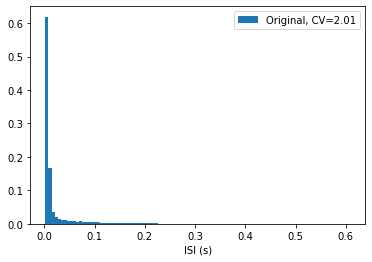

In [10]:
ISI_rho = get_ISI(t_rho)
CV_rho = cv(ISI_rho)
get_ISI(t_rho,hist=True,label=f'Original, CV={CV_rho}')

plt.legend();

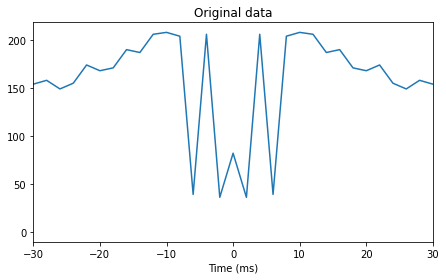

In [11]:
batch = int(rho.shape[0]/100)
corr_rho = np.correlate(rho[0:batch+1],rho[0:batch+1],mode='full')

fig = plt.figure(figsize=(12,4))

fig.add_subplot(1,2,1)
time_p = np.arange(-t_stim/100,t_stim/100+t_res/2,t_res)*1000
plt.plot(time_p,corr_rho);
plt.title('Original data')
plt.xlim(-30,30)
plt.xlabel('Time (ms)')

plt.tight_layout() 